# Experiment Notebook 
#### This notebook is meant to experiment with different parameters, architectures, and normalization methods associated with the gRNA2knockdown Library.
#### The basic characteristic of the model as developed by Enoch Yeung are still preserved in the __main__ function of the module.

In [1]:
import os
import csv
import numpy as np
import platereadertools as prt
import gRNA2knockdown as g2k 

import matplotlib.pyplot as plt 
import tensorflow as tf

2024-02-19 11:45:49.298257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### First Let's import or data, the description of which is below:
- The sequencing data is imported as a CSV and contains gRNA designs which tile the target (GFP) with 3bp of overlap.
- The time series data is imported as a TSV text file generated BioTek's Gen5 software and from data collected on Synergy H1s.
- The experimental design is:
  - Total run time = 18 hours
  - Time step = 3 min.
  - Reads:
    - OD600: Absorbance at 600 nm
    - Fluorescence: Excitation = 480 nm, Emission = 510 nm.
  - Runs where conducted with breath-easy film to reduce moisture loss.

In [2]:
# First we need to load the data
data_fp = "Data/"
spacer_fp = os.path.join(data_fp, "GFP_spacers.gbk")
data_0nM_fp = os.path.join(data_fp,
                            "p2x11_80memberlibrary_0mMIPTG20230730.txt")
data_10mM_fp = os.path.join(data_fp,
                            "p2x11_80memberlib_10mMIPTG20230730.txt")

# Organize the label, sequence data from platereadertools and the csv standard module.
seqs = csv.reader(open("Data/GFP_spacers.csv"))
allseqs = [seq for seq in seqs]
data0, time0 = prt.Organize(data_0nM_fp, 8, 12, 18, 3/60)
data1, time1 = prt.Organize(data_10mM_fp, 8, 12, 18, 3/60)

# Based off of the timeseries data, we can see that the greatest change in flourescence occurs at timepoint 165 
# (~8hours). We will use this timepoint to calculate the fold change between the 0mM and 10mM data.
reads = list(data0.keys())
data_pt0 = data0[reads[1]][:,:,165]
data_pt1 = data1[reads[1]][:,:,165]

# Calculate the fold change between the 0mM and 10mM data.
fold_change = data_pt1/data_pt0
data = np.reshape(fold_change,(96))

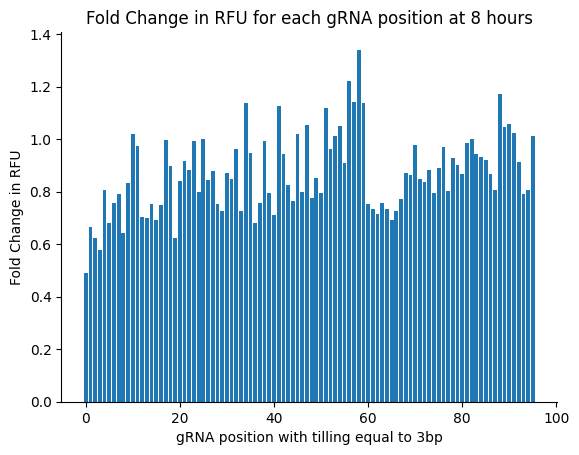

In [3]:
fig, ax = plt.subplots(1,1)
ax.bar(range(len(data)), data)
ax.set_xlabel("gRNA position with tilling equal to 3bp")
ax.set_ylabel('Fold Change in RFU')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Fold Change in RFU for each gRNA position at 8 hours")
if True:
    plt.savefig("./Figures/foldchange.png")

### Define the gRNA2knockdown model parameters.
- The size of the gRNAs is 30 bp, so it makes may make sense to make the intermediate layers 30 nodes.
- For now lets keep the embedding space the same size, and not try to use the resnet functionality.

In [51]:
stride_parameter = 2
label_dim = 1
embedding_dim = 5
intermediate_dim = 2
batch_size_parameter=300 #4000 for howard's e. coli dataset (from Enoch's code)
debug_splash = 0
this_step_size_val = 0.25
this_corpus, this_labels = g2k.make_labeled_corpus(allseqs, data, stride_parameter)

In [52]:
# Define the random transformation householder matrix.
Rand_Transform = g2k.rvs(dim=stride_parameter)

# Define the corpus for the model.
this_corpus_vec = []
for this_corpus_elem in this_corpus:
    vec_value = g2k.sequence_encoding(this_corpus_elem)
    vec_value = np.dot(Rand_Transform,vec_value)
    this_corpus_vec.append(vec_value)

this_corpus_vec = np.asarray(this_corpus_vec)
this_labels = np.expand_dims(this_labels,axis=1)
hidden_vars_list = [embedding_dim, stride_parameter]
print(hidden_vars_list)

[5, 2]


In [53]:
2784/96

29.0

### Build the model.

In [59]:
# Define the tensorflow session
sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution() # needed because of placeholder variables

this_u = tf.compat.v1.placeholder(tf.float32, 
                                    shape=[None,stride_parameter])

with tf.device('/cpu:0'):
    this_W_list,this_b_list = g2k.initialize_Wblist(stride_parameter,
                                                hidden_vars_list)
    this_y_out,all_layers = g2k.network_assemble(this_u,this_W_list,this_b_list
                                            ,keep_prob=1.0,
                                            activation_flag=2,res_net=0)

this_embedding = all_layers[-2]
regress_list = [intermediate_dim]*1+[label_dim]


Length of hv_list: 2
shape: 
shape: 
n_depth: 2


In [60]:

HybridLoss = g2k.customLoss(this_y_out,this_u,this_embedding)
this_optim = tf.compat.v1.train.AdagradOptimizer(
    learning_rate=this_step_size_val).minimize(HybridLoss)
step_size = tf.compat.v1.placeholder(tf.float32,shape=[])
result = sess.run(tf.compat.v1.global_variables_initializer())
this_vae_loss = g2k.vae_loss(this_y_out,this_u)
this_embed_loss = g2k.embed_loss(this_u,this_embedding)

In [61]:
g2k.train_net(sess, this_corpus_vec, this_u, HybridLoss,
              this_optim,batchsize=batch_size_parameter, 
              this_vae_loss=this_vae_loss, 
              this_embed_loss=this_embed_loss,
              step_size_val=this_step_size_val*0.20,
              max_iters=5e4,save_fig='Figures/stepsize0_05.png')

 step 1 , validation error 4.96041
 step 1 , test error 4.99453
 Reconstruction Loss: 0.68247724
 Embedding Loss: 3.9371912
 step 10 , validation error 0.765382
 step 10 , test error 0.671743
 Reconstruction Loss: 0.38932213
 Embedding Loss: 0.26859906
 step 20 , validation error 0.756958
 step 20 , test error 0.702061
 Reconstruction Loss: 0.38629812
 Embedding Loss: 0.30802172
 step 30 , validation error 0.581446
 step 30 , test error 0.503997
 Reconstruction Loss: 0.2606658
 Embedding Loss: 0.2409441
 step 40 , validation error 0.58086
 step 40 , test error 0.529288
 Reconstruction Loss: 0.27378225
 Embedding Loss: 0.25546604
 step 50 , validation error 0.507057
 step 50 , test error 0.45495
 Reconstruction Loss: 0.2752947
 Embedding Loss: 0.20293842
 step 60 , validation error 0.472476
 step 60 , test error 0.42598
 Reconstruction Loss: 0.22562979
 Embedding Loss: 0.20308314
 step 70 , validation error 0.544705
 step 70 , test error 0.507833
 Reconstruction Loss: 0.2954584
 Embeddi

([[0.03296584,
   0.0217529,
   0.01758396,
   0.014593143,
   0.011756919,
   0.010860836,
   0.010609131],
  [0.04106022,
   0.027925996,
   0.02057701,
   0.016864648,
   0.014463284,
   0.012980723,
   0.011981785],
  [0.030799907,
   0.021399252,
   0.016797645,
   0.014456341,
   0.012295367,
   0.0111304615,
   0.010402132]],
 1)

In [57]:
print(this_y_out.eval(feed_dict={this_u:[this_corpus_vec[2]]}, session=sess))
z_ind = this_y_out.eval(feed_dict={this_u:[this_corpus_vec[2]]}, session=sess)
print(this_corpus_vec[2])
print(this_corpus[2])

[[-0.06995612  0.7892881 ]]
[-0.06650193  0.78776741]
GA


1.0

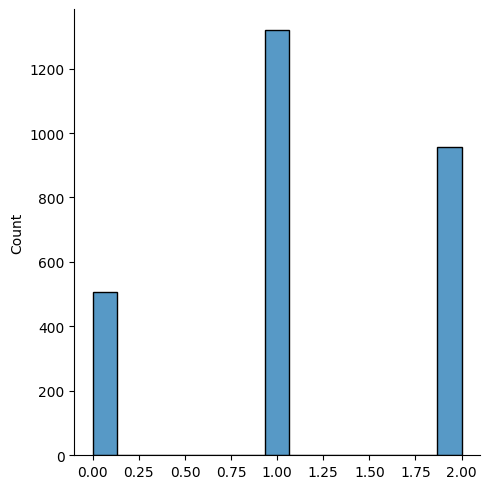

In [58]:
import seaborn as sns;
all_mismatches = []
for ind in range(0,len(this_corpus_vec)):
    z_ind = this_y_out.eval(feed_dict={this_u:[this_corpus_vec[ind]]}, session=sess)
    this_seq_out = g2k.vecback2seq(np.dot(np.linalg.inv(Rand_Transform),z_ind.T))
    this_seq_out = ''.join(this_seq_out)
    all_mismatches.append(g2k.num_mismatch(this_seq_out,this_corpus[ind]));
hist_data = sns.displot(all_mismatches)
mismatch_process = np.array(all_mismatches);
mismatch_process[mismatch_process<=2.0] = 1.0;
mismatch_process[mismatch_process>2.0] = 0.0;
np.sum(mismatch_process)/(len(mismatch_process)*1.0)